# Machine Learning Project

Spotify dataset

In [1]:
library(corrplot)
library(FactoMineR)

corrplot 0.84 loaded



In [2]:
spotify_data <- read.table(file = "data/spotify-extr.txt", header = T, sep = " ")

In [3]:
head(spotify_data)

,valence,year,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,pop.class
,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
161704,0.647,1975,0.4490,0.376,298840,0.827,7.88e-03,B,0.466,-7.604,1,25,0.3990,170.475,C
168077,0.150,2008,0.8990,0.508,236800,0.169,1.12e-05,Ab,0.136,-11.332,1,42,0.0553,107.477,B
35922,0.423,2007,0.0185,0.470,301093,0.878,8.39e-02,B,0.276,-5.576,0,65,0.0377,150.093,A
135823,0.302,1995,0.0384,0.176,142200,0.980,5.52e-01,B,0.237,-3.154,1,36,0.0721,172.566,C
165395,0.828,1994,0.5310,0.705,187800,0.625,7.73e-06,G,0.348,-11.963,0,38,0.0639,97.831,C
38184,0.489,2018,0.3710,0.856,324189,0.694,0.00e+00,D,0.109,-4.393,1,68,0.1690,122.080,A


In [4]:
dim(spotify_data)

[1] 10000    15

In [5]:
sapply(spotify_data, class)

valence             year     acousticness     danceability 
       "numeric"        "integer"        "numeric"        "numeric" 
        duration           energy instrumentalness              key 
       "integer"        "numeric"        "numeric"      "character" 
        liveness         loudness             mode       popularity 
       "numeric"        "numeric"        "integer"        "integer" 
     speechiness            tempo        pop.class 
       "numeric"        "numeric"      "character"

In [6]:
spotify_data$pop.class <- factor(spotify_data$pop.class, order = T)
spotify_data$key <- factor(spotify_data$key)

In [7]:
levels(spotify_data$pop.class)

[1] "A" "B" "C" "D"

In [8]:
percentage <- prop.table(table(spotify_data$pop.class)) * 100
cbind(freq = table(spotify_data$pop.class), percentage = percentage)

,freq,percentage
A,963,9.63
B,2886,28.86
C,2968,29.68
D,3183,31.83


In [9]:
summary(spotify_data)

    valence            year       acousticness      danceability  
 Min.   :0.0000   Min.   :1921   Min.   :0.00000   Min.   :0.000  
 1st Qu.:0.3240   1st Qu.:1956   1st Qu.:0.09267   1st Qu.:0.417  
 Median :0.5430   Median :1978   Median :0.50400   Median :0.550  
 Mean   :0.5328   Mean   :1977   Mean   :0.49572   Mean   :0.540  
 3rd Qu.:0.7510   3rd Qu.:1999   3rd Qu.:0.88925   3rd Qu.:0.671  
 Max.   :0.9930   Max.   :2020   Max.   :0.99600   Max.   :0.988  
                                                                  
    duration           energy       instrumentalness        key      
 Min.   :   5991   Min.   :0.0000   Min.   :0.000000   C      :1282  
 1st Qu.: 169067   1st Qu.:0.2620   1st Qu.:0.000000   G      :1188  
 Median : 206530   Median :0.4760   Median :0.000174   D      :1092  
 Mean   : 227215   Mean   :0.4875   Mean   :0.164947   A      :1050  
 3rd Qu.: 259733   3rd Qu.:0.7080   3rd Qu.:0.087100   F      : 961  
 Max.   :2703227   Max.   :1.0000   Max.   :

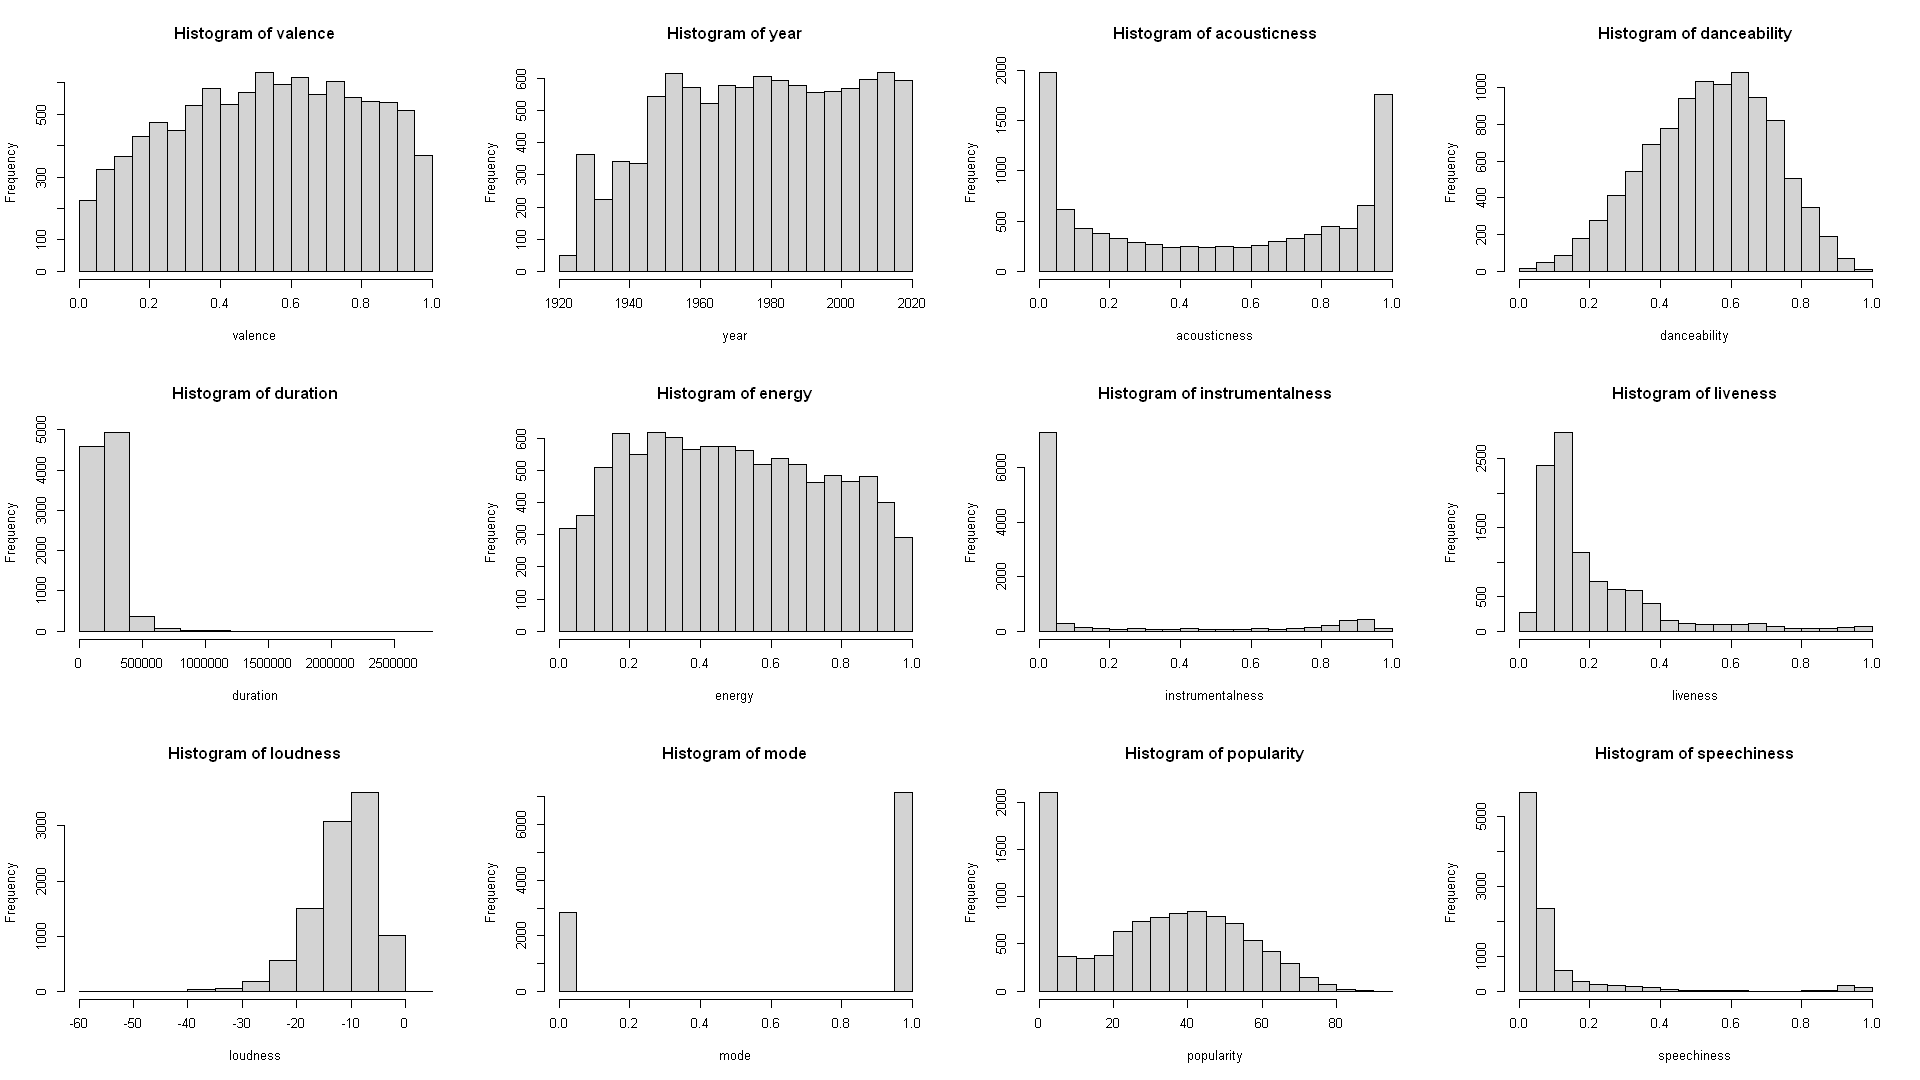

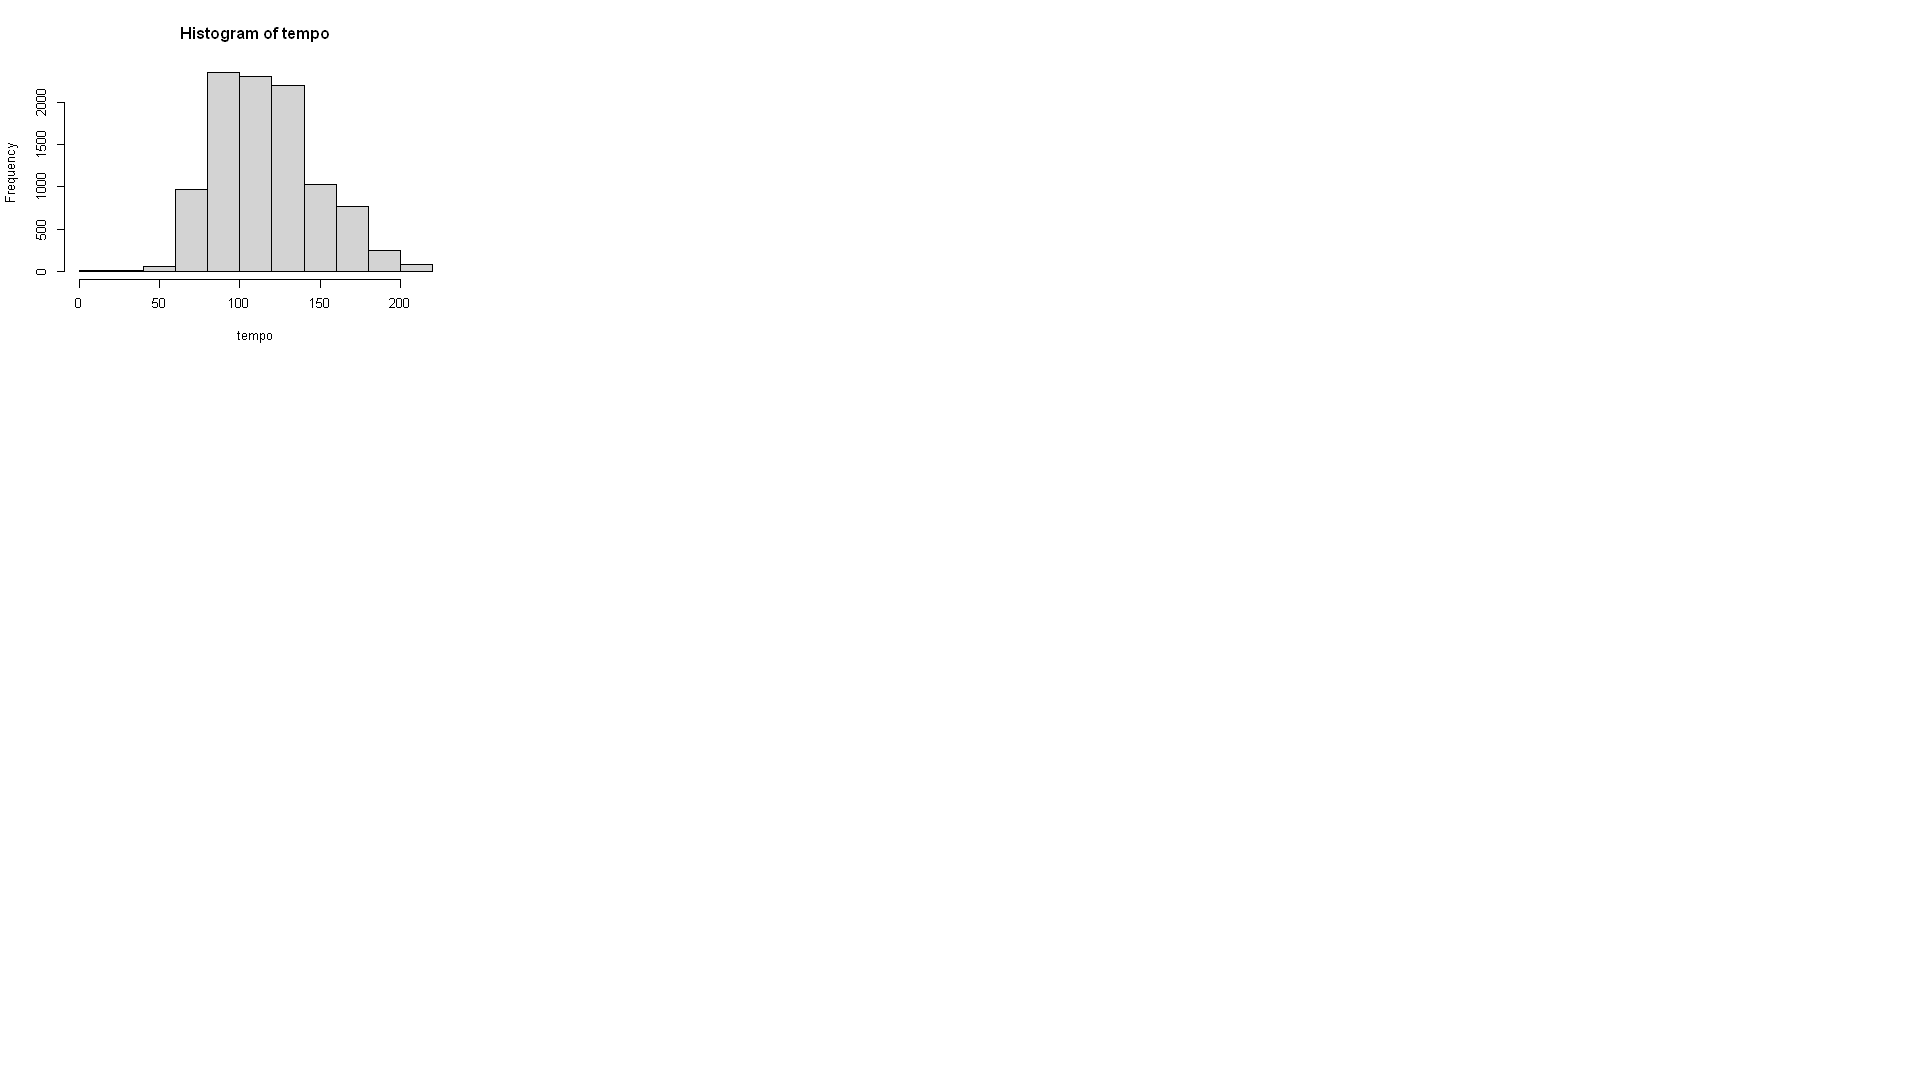

In [10]:
data_quant <- spotify_data[,-c(8, 15)]

options(repr.plot.width = 16, repr.plot.height = 9)
par(mfrow = c(3, 4))
for (i in 1:13) {
    hist(data_quant[, i],
         main=paste('Histogram of', colnames(data_quant)[i], sep=" "), 
         xlab=colnames(data_quant)[i])
}

In [11]:
library(caret)

val_index <- createDataPartition(spotify_data$pop.class, p = 0.67, list = F)
validation <- spotify_data[-val_index, ]
spotify_data <- spotify_data[val_index, ]

Loading required package: lattice

Loading required package: ggplot2



In [12]:
library(dplyr)

excluded_vars <- c("popularity", "pop.class")
X <- spotify_data %>% select(!all_of(excluded_vars))
y_reg <- dplyr::select(spotify_data, popularity)
y_class <- dplyr::select(spotify_data, pop.class)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [13]:
head(X)

,valence,year,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
161704,0.647,1975,0.4490,0.376,298840,0.827,7.88e-03,B,0.4660,-7.604,1,0.3990,170.475
168077,0.150,2008,0.8990,0.508,236800,0.169,1.12e-05,Ab,0.1360,-11.332,1,0.0553,107.477
35922,0.423,2007,0.0185,0.470,301093,0.878,8.39e-02,B,0.2760,-5.576,0,0.0377,150.093
135823,0.302,1995,0.0384,0.176,142200,0.980,5.52e-01,B,0.2370,-3.154,1,0.0721,172.566
165395,0.828,1994,0.5310,0.705,187800,0.625,7.73e-06,G,0.3480,-11.963,0,0.0639,97.831
11675,0.411,1980,0.3600,0.602,312773,0.732,3.14e-04,D,0.0755,-8.290,1,0.0282,129.355


In [14]:
head(y_reg)

,popularity
,<int>
161704,25
168077,42
35922,65
135823,36
165395,38
11675,61
